In [5]:
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, BatchNormalization, Activation, Dropout, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

es = EarlyStopping(monitor='val_acc', mode='max', min_delta=.005, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_shallow_conv.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [9]:
X_train = np.load("data\X_train_valid.npy")
y_train = np.load("data\y_train_valid.npy")

X_test = np.load("data\X_test.npy")
y_test = np.load("data\y_test.npy")

person_train = np.ravel(np.load("data\person_train_valid.npy"))
person_test = np.ravel(np.load("data\person_test.npy"))

In [10]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
def get_train_val_split(data, targets, person_data, val_size=0.2):
    
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    sss.get_n_splits(data, targets)

    X = data
    y = targets
    p = person_data

    for train_index, val_index in sss.split(data, targets):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        person_train, person_val = p[train_index], p[val_index]
        
    return X_train, y_train, X_val, y_val, person_train, person_val

# X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, person_train.shape, person_val.shape)

def clean_data(X, y):
    # REMOVE EOG DATA
    X = X[:,:-3,:]
    # RESET Y VALUES and ONE HOT ENCODE
    y = y % 769.0
    print('Data cleaned... X shape = {}, y shape = {}'.format(X.shape, y.shape))
    return X, y

# X_train, y_train = clean_data(X_train, y_train)

def get_train_val_test_for_subject(X_train,
                                   y_train,
                                   X_val, 
                                   y_val,
                                   X_test, 
                                   y_test,
                                   person_train, 
                                   person_val, 
                                   person_test, 
                                   subject=0):
    
    X_train = np.squeeze(X_train[np.argwhere(person_train == subject)])
    y_train = np.squeeze(y_train[np.argwhere(person_train == subject)])
    X_val = np.squeeze(X_val[np.argwhere(person_val == subject)])
    y_val = np.squeeze(y_val[np.argwhere(person_val == subject)])
    X_test = np.squeeze(X_test[np.argwhere(person_test == subject)])
    y_test = np.squeeze(y_test[np.argwhere(person_test == subject)])
    
    print('Data for subject {}'.format(subject))
    print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_val shape', X_val.shape)
    print('y_val shape', y_val.shape)
    print('X_test shape', X_test.shape)
    print('y_test shape', y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
#                                                                                             X_val, y_val,
#                                                                                             X_test, y_test,
#                                                                                             person_train, 
#                                                                                             person_val, 
#                                                                                             person_test,
#                                                                                             subject=0)

In [12]:
X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)

X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Targting one specific subject
X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
                                                                                            X_val, y_val,
                                                                                            X_test, y_test,
                                                                                            person_train, 
                                                                                            person_val, 
                                                                                            person_test,
                                                                                            subject=0)

# X_train = scale_then_smooth(X_train)
# X_val = scale_then_smooth(X_val)
# X_test = scale_then_smooth(X_test)

Data cleaned... X shape = (1692, 22, 1000), y shape = (1692,)
Data cleaned... X shape = (423, 22, 1000), y shape = (423,)
Data cleaned... X shape = (443, 22, 1000), y shape = (443,)
Data for subject 0
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (47, 22, 1000)
y_val shape (47,)
X_test shape (50, 22, 1000)
y_test shape (50,)


### Test on All subjects

In [8]:
# train_x, train_y = X_train_0, y_train_0
# val_x, val_y = X_val_0, y_val_0
# test_x, test_y = X_test_0, y_test_0 

train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

trials, electrodes, timesteps = train_x.shape

ki='glorot_normal'

model = Sequential()

# Conv Pool Block 1
model.add(Conv2D(filters=40, kernel_size=(25,1), input_shape=(1000, 22, 1), kernel_initializer=ki, data_format="channels_last"))
model.add(Conv2D(filters=40, kernel_size=(1,22)), kernel_initializer=ki)
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(AveragePooling2D(pool_size = (75,1), strides = (15,1)))
model.add(Dropout(0.5))

# Classification Layer
model.add(Flatten())
model.add(Dense(units=4, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_x = train_x.transpose((0,2,1))[:, :, :, None]
val_x = val_x.transpose((0,2,1))[:, :, :, None]
test_x = test_x.transpose((0,2,1))[:, :, :, None]

history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_data = (val_x, val_y), callbacks=[es, mc])
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

plot_history(history)

Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 49s 29ms/step - loss: 1.4058 - acc: 0.3233 - val_loss: 1.3169 - val_acc: 0.3948
Epoch 2/50
1692/1692 [==============================] - 48s 29ms/step - loss: 1.2685 - acc: 0.4161 - val_loss: 1.2221 - val_acc: 0.4823
Epoch 3/50
1692/1692 [==============================] - 49s 29ms/step - loss: 1.1728 - acc: 0.4923 - val_loss: 1.2067 - val_acc: 0.5106
Epoch 4/50
1692/1692 [==============================] - 48s 28ms/step - loss: 1.1045 - acc: 0.5319 - val_loss: 1.0938 - val_acc: 0.5508
Epoch 5/50
1692/1692 [==============================] - 48s 28ms/step - loss: 1.0442 - acc: 0.5538 - val_loss: 1.0901 - val_acc: 0.5272
Epoch 6/50
1692/1692 [==============================] - 48s 29ms/step - loss: 1.0054 - acc: 0.5993 - val_loss: 1.0718 - val_acc: 0.5485
Epoch 7/50
1692/1692 [==============================] - 49s 29ms/step - loss: 0.9425 - acc: 0.6277 - val_loss: 1.0348 - val_acc: 0.5556
E

NameError: name 'plt' is not defined

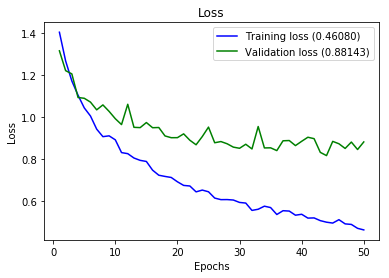

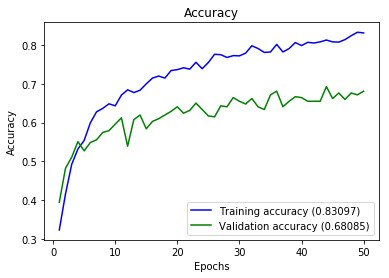

In [10]:
plot_history(history)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 976, 22, 40)       1040      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 976, 1, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 976, 1, 40)        160       
_________________________________________________________________
activation_2 (Activation)    (None, 976, 1, 40)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 61, 1, 40)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 1, 40)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2440)              0         
__________

In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model('best_shallow_conv.h5')

In [15]:
subject_scores = {}
for i in np.arange(9):
    X_train_i, y_train_i, X_val_i, y_val_i, X_test_i, y_test_i = get_train_val_test_for_subject(X_train, y_train,
                                                                                            X_val, y_val,
                                                                                            X_test, y_test,
                                                                                            person_train, 
                                                                                            person_val, 
                                                                                            person_test,
                                                                                            subject=i)
    
    test_x_i = X_test_i.transpose((0,2,1))[:, :, :, None]
    subject_scores[i] = model.evaluate(test_x_i, y_test_i, batch_size=32)
    
subject_scores

Data for subject 0
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (47, 22, 1000)
y_val shape (47,)
X_test shape (50, 22, 1000)
y_test shape (50,)
50/50 [==============================] - 0s 9ms/step
Data for subject 1
X_train shape (181, 22, 1000)
y_train shape (181,)
X_val shape (55, 22, 1000)
y_val shape (55,)
X_test shape (50, 22, 1000)
y_test shape (50,)
50/50 [==============================] - 0s 6ms/step
Data for subject 2
X_train shape (188, 22, 1000)
y_train shape (188,)
X_val shape (48, 22, 1000)
y_val shape (48,)
X_test shape (50, 22, 1000)
y_test shape (50,)
50/50 [==============================] - 0s 8ms/step
Data for subject 3
X_train shape (184, 22, 1000)
y_train shape (184,)
X_val shape (50, 22, 1000)
y_val shape (50,)
X_test shape (50, 22, 1000)
y_test shape (50,)
50/50 [==============================] - 0s 7ms/step
Data for subject 4
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (45, 22, 1000)
y_val shape (45,)
X_test shape (47, 22, 100

{0: [0.9719117784500122, 0.6400000071525573],
 1: [1.0671474885940553, 0.5600000071525574],
 2: [0.5925392985343934, 0.7999999952316285],
 3: [0.7484891295433045, 0.6999999952316284],
 4: [0.6067543283421942, 0.7872340476259272],
 5: [0.8704776107048502, 0.6530612250980066],
 6: [0.7184607791900635, 0.6600000095367432],
 7: [0.7317169666290283, 0.7200000047683716],
 8: [0.7790890221900129, 0.7872340463577433]}

No handles with labels found to put in legend.


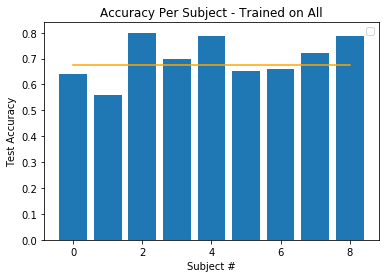

No handles with labels found to put in legend.


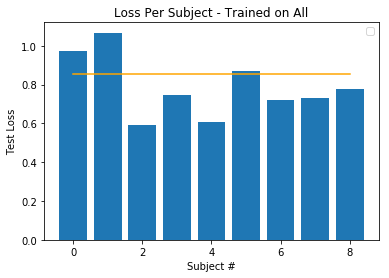

In [25]:
subjects = list(subject_scores)
loss = np.array(list(subject_scores.values()))[:,0]
acc = np.array(list(subject_scores.values()))[:,1]

plt.bar(subjects, acc)
plt.plot(subjects, [0.6749]*9, color='orange')
plt.title('Accuracy Per Subject - Trained on All')
plt.xlabel('Subject #')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

plt.bar(subjects, loss)
plt.plot(subjects, [0.8531]*9, color='orange')
plt.title('Loss Per Subject - Trained on All')
plt.xlabel('Subject #')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

## Test on specific subjects

Beginning test for subject 0
Data for subject 0
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (47, 22, 1000)
y_val shape (47,)
X_test shape (50, 22, 1000)
y_test shape (50,)
Train on 190 samples, validate on 47 samples
Epoch 1/50
190/190 [==============================] - 4s 21ms/step - loss: 1.5390 - acc: 0.3211 - val_loss: 1.4223 - val_acc: 0.3830
Epoch 2/50
190/190 [==============================] - 3s 18ms/step - loss: 1.2419 - acc: 0.4474 - val_loss: 1.5639 - val_acc: 0.3404
Epoch 3/50
190/190 [==============================] - 3s 17ms/step - loss: 1.2270 - acc: 0.4211 - val_loss: 1.5202 - val_acc: 0.3191
Epoch 4/50
190/190 [==============================] - 3s 18ms/step - loss: 1.1149 - acc: 0.5316 - val_loss: 1.4121 - val_acc: 0.3191
Epoch 5/50
190/190 [==============================] - 3s 18ms/step - loss: 1.1015 - acc: 0.5316 - val_loss: 1.4268 - val_acc: 0.2766
Epoch 6/50
190/190 [==============================] - 4s 20ms/step - loss: 1.0347 - acc: 0.6105 - v

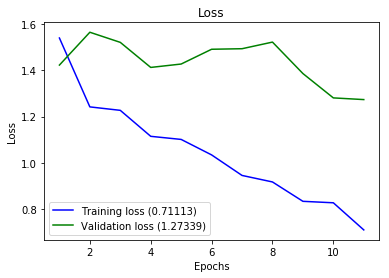

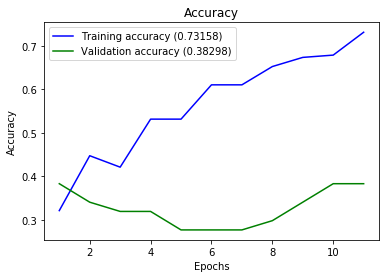

Beginning test for subject 1
Data for subject 1
X_train shape (181, 22, 1000)
y_train shape (181,)
X_val shape (55, 22, 1000)
y_val shape (55,)
X_test shape (50, 22, 1000)
y_test shape (50,)
Train on 181 samples, validate on 55 samples
Epoch 1/50
181/181 [==============================] - 4s 24ms/step - loss: 1.5550 - acc: 0.2431 - val_loss: 1.4351 - val_acc: 0.4000
Epoch 2/50
181/181 [==============================] - 4s 21ms/step - loss: 1.3084 - acc: 0.4144 - val_loss: 1.3805 - val_acc: 0.3455
Epoch 3/50
181/181 [==============================] - 4s 22ms/step - loss: 1.1346 - acc: 0.4696 - val_loss: 1.3685 - val_acc: 0.3273
Epoch 4/50
181/181 [==============================] - 4s 22ms/step - loss: 1.0352 - acc: 0.5525 - val_loss: 1.3736 - val_acc: 0.3636
Epoch 5/50
181/181 [==============================] - 4s 21ms/step - loss: 1.0388 - acc: 0.5525 - val_loss: 1.3350 - val_acc: 0.4182
Epoch 6/50
181/181 [==============================] - 4s 21ms/step - loss: 0.9537 - acc: 0.5912 - v

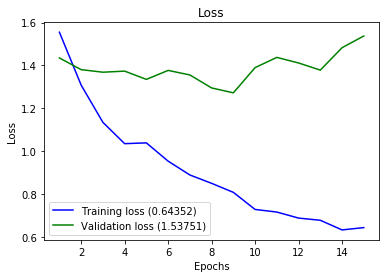

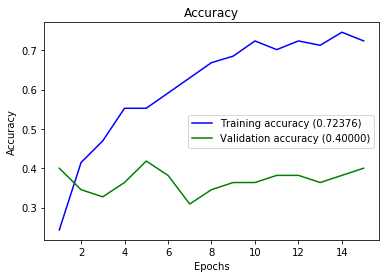

Beginning test for subject 2
Data for subject 2
X_train shape (188, 22, 1000)
y_train shape (188,)
X_val shape (48, 22, 1000)
y_val shape (48,)
X_test shape (50, 22, 1000)
y_test shape (50,)
Train on 188 samples, validate on 48 samples
Epoch 1/50
188/188 [==============================] - 4s 24ms/step - loss: 1.4720 - acc: 0.2500 - val_loss: 1.3974 - val_acc: 0.3542
Epoch 2/50
188/188 [==============================] - 4s 21ms/step - loss: 1.3736 - acc: 0.3457 - val_loss: 1.3405 - val_acc: 0.4375
Epoch 3/50
188/188 [==============================] - 4s 21ms/step - loss: 1.2525 - acc: 0.4362 - val_loss: 1.3765 - val_acc: 0.4167
Epoch 4/50
188/188 [==============================] - 4s 21ms/step - loss: 1.1467 - acc: 0.5372 - val_loss: 1.2918 - val_acc: 0.4167
Epoch 5/50
188/188 [==============================] - 4s 21ms/step - loss: 1.0045 - acc: 0.6117 - val_loss: 1.2905 - val_acc: 0.4375
Epoch 6/50
188/188 [==============================] - 4s 22ms/step - loss: 0.9394 - acc: 0.6170 - v

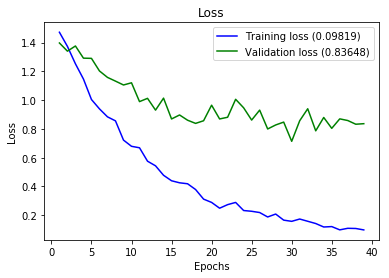

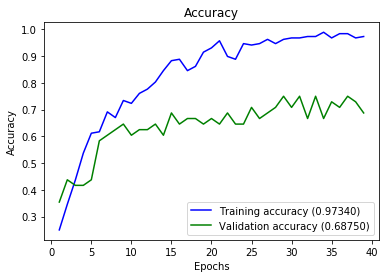

Beginning test for subject 3
Data for subject 3
X_train shape (184, 22, 1000)
y_train shape (184,)
X_val shape (50, 22, 1000)
y_val shape (50,)
X_test shape (50, 22, 1000)
y_test shape (50,)
Train on 184 samples, validate on 50 samples
Epoch 1/50
184/184 [==============================] - 6s 32ms/step - loss: 1.5508 - acc: 0.2772 - val_loss: 1.4765 - val_acc: 0.2600
Epoch 2/50
184/184 [==============================] - 5s 25ms/step - loss: 1.3363 - acc: 0.3967 - val_loss: 1.4956 - val_acc: 0.2400
Epoch 3/50
184/184 [==============================] - 5s 25ms/step - loss: 1.1940 - acc: 0.4837 - val_loss: 1.4030 - val_acc: 0.3200
Epoch 4/50
184/184 [==============================] - 5s 25ms/step - loss: 1.1858 - acc: 0.4728 - val_loss: 1.3442 - val_acc: 0.3200
Epoch 5/50
184/184 [==============================] - 5s 26ms/step - loss: 1.1215 - acc: 0.5380 - val_loss: 1.3548 - val_acc: 0.4000
Epoch 6/50
184/184 [==============================] - 4s 23ms/step - loss: 0.9979 - acc: 0.5815 - v

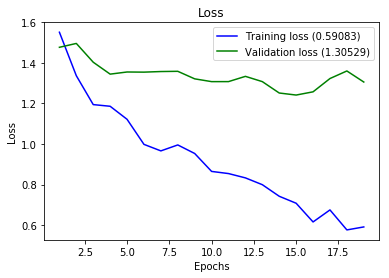

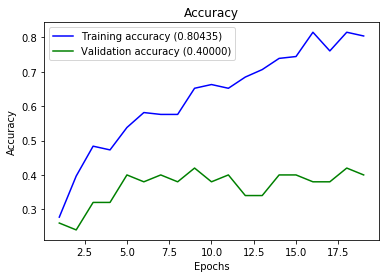

Beginning test for subject 4
Data for subject 4
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (45, 22, 1000)
y_val shape (45,)
X_test shape (47, 22, 1000)
y_test shape (47,)
Train on 190 samples, validate on 45 samples
Epoch 1/50
190/190 [==============================] - 5s 24ms/step - loss: 1.5003 - acc: 0.2684 - val_loss: 1.3616 - val_acc: 0.3778
Epoch 2/50
190/190 [==============================] - 4s 22ms/step - loss: 1.2143 - acc: 0.4421 - val_loss: 1.3064 - val_acc: 0.3556
Epoch 3/50
190/190 [==============================] - 4s 22ms/step - loss: 1.0874 - acc: 0.5316 - val_loss: 1.2523 - val_acc: 0.4889
Epoch 4/50
190/190 [==============================] - 4s 21ms/step - loss: 0.9899 - acc: 0.5947 - val_loss: 1.2289 - val_acc: 0.5333
Epoch 5/50
190/190 [==============================] - 4s 23ms/step - loss: 0.8472 - acc: 0.6895 - val_loss: 1.1856 - val_acc: 0.5556
Epoch 6/50
190/190 [==============================] - 4s 21ms/step - loss: 0.7863 - acc: 0.7211 - v

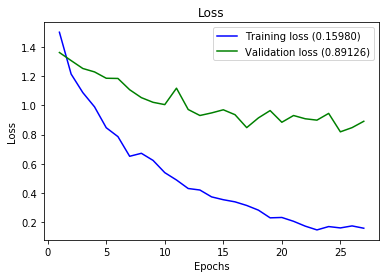

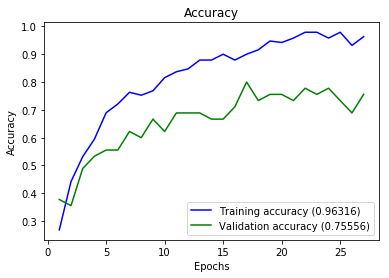

Beginning test for subject 5
Data for subject 5
X_train shape (193, 22, 1000)
y_train shape (193,)
X_val shape (43, 22, 1000)
y_val shape (43,)
X_test shape (49, 22, 1000)
y_test shape (49,)
Train on 193 samples, validate on 43 samples
Epoch 1/50
193/193 [==============================] - 5s 25ms/step - loss: 1.5289 - acc: 0.3057 - val_loss: 1.5144 - val_acc: 0.2093
Epoch 2/50
193/193 [==============================] - 4s 21ms/step - loss: 1.3336 - acc: 0.4145 - val_loss: 1.4194 - val_acc: 0.3256
Epoch 3/50
193/193 [==============================] - 4s 21ms/step - loss: 1.2411 - acc: 0.4352 - val_loss: 1.3505 - val_acc: 0.4419
Epoch 4/50
193/193 [==============================] - 4s 21ms/step - loss: 1.1943 - acc: 0.4301 - val_loss: 1.3685 - val_acc: 0.3953
Epoch 5/50
193/193 [==============================] - 4s 21ms/step - loss: 1.1588 - acc: 0.5337 - val_loss: 1.4213 - val_acc: 0.3953
Epoch 6/50
193/193 [==============================] - 4s 22ms/step - loss: 1.1526 - acc: 0.5181 - v

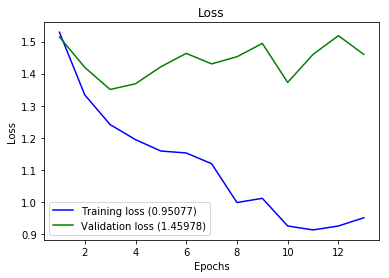

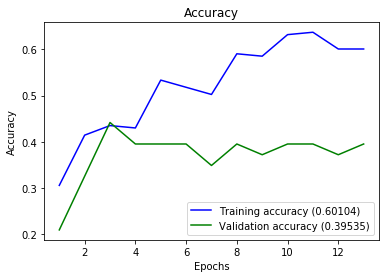

Beginning test for subject 6
Data for subject 6
X_train shape (197, 22, 1000)
y_train shape (197,)
X_val shape (41, 22, 1000)
y_val shape (41,)
X_test shape (50, 22, 1000)
y_test shape (50,)
Train on 197 samples, validate on 41 samples
Epoch 1/50
197/197 [==============================] - 5s 26ms/step - loss: 1.5075 - acc: 0.2437 - val_loss: 1.2840 - val_acc: 0.3415
Epoch 2/50
197/197 [==============================] - 4s 21ms/step - loss: 1.1886 - acc: 0.4670 - val_loss: 1.1940 - val_acc: 0.4634
Epoch 3/50
197/197 [==============================] - 4s 20ms/step - loss: 1.1404 - acc: 0.5279 - val_loss: 1.1440 - val_acc: 0.5122
Epoch 4/50
197/197 [==============================] - 4s 21ms/step - loss: 1.0009 - acc: 0.5838 - val_loss: 1.0389 - val_acc: 0.5854
Epoch 5/50
197/197 [==============================] - 4s 21ms/step - loss: 0.8890 - acc: 0.6497 - val_loss: 0.9581 - val_acc: 0.5854
Epoch 6/50
197/197 [==============================] - 4s 23ms/step - loss: 0.8538 - acc: 0.6244 - v

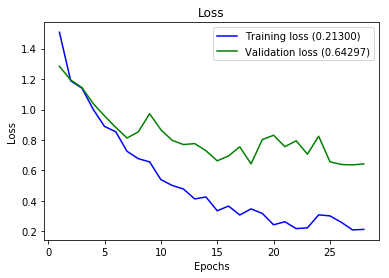

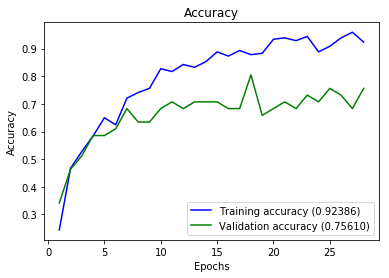

Beginning test for subject 7
Data for subject 7
X_train shape (193, 22, 1000)
y_train shape (193,)
X_val shape (39, 22, 1000)
y_val shape (39,)
X_test shape (50, 22, 1000)
y_test shape (50,)
Train on 193 samples, validate on 39 samples
Epoch 1/50
193/193 [==============================] - 5s 28ms/step - loss: 1.5331 - acc: 0.2746 - val_loss: 1.3633 - val_acc: 0.3590
Epoch 2/50
193/193 [==============================] - 5s 23ms/step - loss: 1.2268 - acc: 0.4767 - val_loss: 1.2972 - val_acc: 0.4103
Epoch 3/50
193/193 [==============================] - 4s 23ms/step - loss: 1.1124 - acc: 0.5440 - val_loss: 1.1893 - val_acc: 0.4359
Epoch 4/50
193/193 [==============================] - 4s 21ms/step - loss: 1.0130 - acc: 0.5907 - val_loss: 1.2043 - val_acc: 0.3333
Epoch 5/50
193/193 [==============================] - 4s 20ms/step - loss: 1.0202 - acc: 0.5751 - val_loss: 1.1651 - val_acc: 0.4359
Epoch 6/50
193/193 [==============================] - 4s 21ms/step - loss: 0.9829 - acc: 0.6062 - v

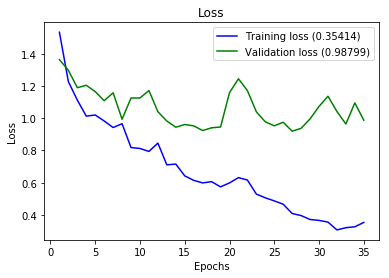

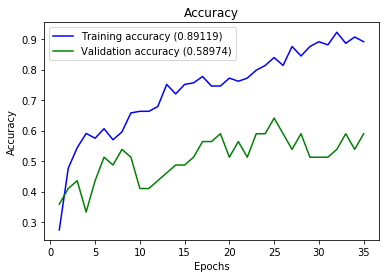

Beginning test for subject 8
Data for subject 8
X_train shape (176, 22, 1000)
y_train shape (176,)
X_val shape (55, 22, 1000)
y_val shape (55,)
X_test shape (47, 22, 1000)
y_test shape (47,)
Train on 176 samples, validate on 55 samples
Epoch 1/50
176/176 [==============================] - 5s 26ms/step - loss: 1.5171 - acc: 0.2557 - val_loss: 1.2123 - val_acc: 0.4182
Epoch 2/50
176/176 [==============================] - 4s 22ms/step - loss: 1.1895 - acc: 0.4773 - val_loss: 1.1121 - val_acc: 0.4545
Epoch 3/50
176/176 [==============================] - 4s 21ms/step - loss: 1.1021 - acc: 0.5739 - val_loss: 1.1586 - val_acc: 0.4182
Epoch 4/50
176/176 [==============================] - 4s 21ms/step - loss: 0.9841 - acc: 0.6307 - val_loss: 1.0605 - val_acc: 0.5455
Epoch 5/50
176/176 [==============================] - 4s 23ms/step - loss: 0.9032 - acc: 0.6534 - val_loss: 1.0303 - val_acc: 0.5636
Epoch 6/50
176/176 [==============================] - 5s 28ms/step - loss: 0.7702 - acc: 0.7557 - v

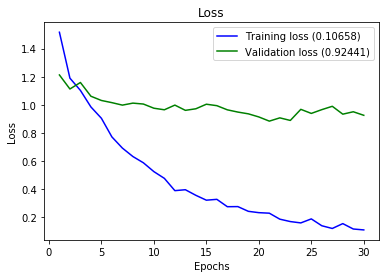

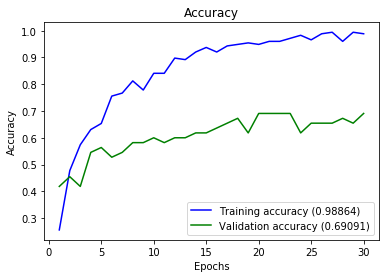

{0: [1.521349868774414, 0.22000000178813933],
 1: [1.4580075979232787, 0.2800000011920929],
 2: [1.1075154304504395, 0.5600000071525574],
 3: [1.391690444946289, 0.4200000011920929],
 4: [0.8718102472893735, 0.6382978748767933],
 5: [1.4000807708623457, 0.38775510234492166],
 6: [0.7584108352661133, 0.6999999952316284],
 7: [1.2914532899856568, 0.5600000071525574],
 8: [0.9105432071584336, 0.5531914982389896]}

In [34]:
subject_scores = {}
for i in np.arange(9):
    
    print('==============================================')
    print('Beginning test for subject', i)
    print('==============================================')
    
    X_train_i, y_train_i, X_val_i, y_val_i, X_test_i, y_test_i = get_train_val_test_for_subject(X_train, y_train,
                                                                                            X_val, y_val,
                                                                                            X_test, y_test,
                                                                                            person_train, 
                                                                                            person_val, 
                                                                                            person_test,
                                                                                            subject=i)

    train_x_i, train_y_i = X_train_i, y_train_i
    val_x_i, val_y_i = X_val_i, y_val_i
    test_x_i, test_y_i = X_test_i, y_test_i

    # train_x, train_y = X_train, y_train
    # val_x, val_y = X_val, y_val
    # test_x, test_y = X_test, y_test

    trials, electrodes, timesteps = train_x_i.shape

    ki='glorot_normal'

    model = Sequential()

    # Conv Pool Block 1
    model.add(Conv2D(filters=40, kernel_size=(25,1), input_shape=(1000, 22, 1), kernel_initializer=ki, data_format="channels_last"))
    model.add(Conv2D(filters=40, kernel_size=(1,22)))
    model.add(BatchNormalization())
    model.add(Activation(activation = 'elu'))
    model.add(AveragePooling2D(pool_size = (75,1), strides = (15,1)))
    model.add(Dropout(0.5))

    # Classification Layer
    model.add(Flatten())
    model.add(Dense(units=4, activation = 'softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    train_x_i = train_x_i.transpose((0,2,1))[:, :, :, None]
    val_x_i = val_x_i.transpose((0,2,1))[:, :, :, None]
    test_x_i = test_x_i.transpose((0,2,1))[:, :, :, None]

    history = model.fit(train_x_i, train_y_i, epochs=50, batch_size=32, validation_data = (val_x_i, val_y_i), callbacks=[es, mc])
    subject_scores[i] = model.evaluate(test_x_i, y_test_i, batch_size=32)

    plot_history(history)
    
subject_scores

No handles with labels found to put in legend.


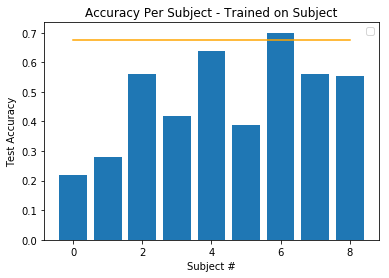

No handles with labels found to put in legend.


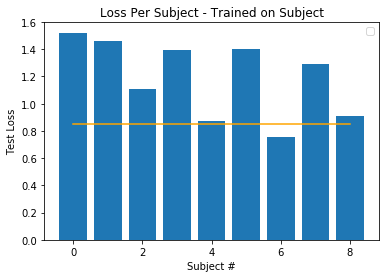

In [35]:
subjects = list(subject_scores)
loss = np.array(list(subject_scores.values()))[:,0]
acc = np.array(list(subject_scores.values()))[:,1]

plt.bar(subjects, acc)
plt.plot(subjects, [0.6749]*9, color='orange')
plt.title('Accuracy Per Subject - Trained on Subject')
plt.xlabel('Subject #')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

plt.bar(subjects, loss)
plt.plot(subjects, [0.8531]*9, color='orange')
plt.title('Loss Per Subject - Trained on Subject')
plt.xlabel('Subject #')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

In [36]:
subjects, loss, acc

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 array([1.52134987, 1.4580076 , 1.10751543, 1.39169044, 0.87181025,
        1.40008077, 0.75841084, 1.29145329, 0.91054321]),
 array([0.22      , 0.28      , 0.56000001, 0.42      , 0.63829787,
        0.3877551 , 0.7       , 0.56000001, 0.5531915 ]))